In [13]:
#读取数据
import pandas as pd
import torch
import torch.nn as nn
import numpy as np


train_data = pd.read_csv("digit-recognizer-data/train.csv")

'''长教训了QAQ，下面这种写法是错误的
trainX=train_data.values[:][1:]
trainY=train_data.values[:][0]
'''
trainX=train_data.values[:,1:]
trainY=train_data.values[:,0]
#print(trainX.shape)
#print(trainY.shape)

test_data = pd.read_csv("digit-recognizer-data/test.csv")
testX=test_data.values[:,:]

#print(train_data.columns)#输出表头信息

def printImage(id): #可以打印成图像输出
    print('数字为 : ' + str( trainY[id] ))
    for i in range(28):
        for j in range(28):
            print('#' if trainX[id][i*28+j] >0 else '.' ,end="")
        print()

#printImage(2333) #打印第2333个数字

In [8]:
class digitRecognizerModel(nn.Module):#神经网络模型
    def __init__(self):
        super().__init__()
        # 输入尺寸1×28×28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,  # 输入通道1 输出通道16
                               kernel_size=(3, 3),  # 卷积核尺寸
                               stride=(1, 1),  # 卷积核每次移动多少个像素
                               padding=1)  # 原图片边缘加几个空白像素
        # conv1输出尺寸16×28×28
        self.pool1 = nn.MaxPool2d(kernel_size=2)  #第一次池化，输出尺寸16×14×14
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)  #第二次卷积，输出尺寸32×14×14
        self.pool2 = nn.MaxPool2d(2)  #第二次池化，输出尺寸32×7×7
        self.zhankai = nn.Flatten()#展平为张量，输出尺寸是一维1568(32*7*7)
        self.lin1 = nn.Linear(32 * 7 * 7, 16)#输出尺寸16
        self.jihuo = nn.ReLU()#激活函数
        self.lin2 = nn.Linear(16, 10)#输出尺寸10
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.zhankai(x)
        x = self.lin1(x)
        x = self.jihuo(x)
        x = self.lin2(x)
        return x

In [9]:
#训练模型，返回1.模型 2.train_losses 3.epoch_losses 4.train_accuracies
def trainModel():
    net = digitRecognizerModel()
    calcLoss = nn.CrossEntropyLoss() #loss用交叉熵来计算
    optimizer = torch.optim.SGD(net.parameters(), lr=0.2) #optimizer是优化器，这里使用SGD随机梯度下降。lr是学习率

    epochs = 10 #迭代次数
    batch_size  = 128 #每批数据的大小为128，那么就有len(trainX)//barch批，每批数据的范围是[i * batch，(i+1) * batch)

    # 记录训练过程
    train_losses = [] #每个batch的损失
    epoch_losses = [] #每个epoch的平均损失
    train_accuracies = [] #每个epoch的准确率

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for i in range(len(trainX)//batch_size ):
            L = i * batch_size  
            R = (i+1) * batch_size 
            tmpX = trainX[L:R] / 255 #取出来这一批的数据并转为0~1的深度
            tmpX = tmpX.reshape(batch_size , 1, 28, 28) #转化形式，变成能输入网络的形式
            tmpX = torch.from_numpy(tmpX).float() #将numpy转为PyTorch张量

            tmpY = trainY[L:R] #Y同理
            tmpY = torch.from_numpy(tmpY)

            outputs = net(tmpX) #得到网络输出

            
            optimizer.zero_grad() #清空模型参数梯度
            loss = calcLoss(outputs, tmpY)
            loss.backward() #计算损失函数对模型参数的梯度
            optimizer.step() #更新模型参数


            #计算准确率
            _, predicted = torch.max(outputs.data, 1) #沿着张量的第1维计算最大值，返回最大值以及索引
            total += tmpY.size(0)
            correct += (predicted == tmpY).sum().item()
            #记录当前batch损失
            current_loss = loss.item()
            train_losses.append(current_loss)
            epoch_loss += current_loss
        
        #计算epoch指标
        epoch_losses.append(epoch_loss / (len(trainX) // batch_size))
        train_accuracies.append(100 * correct / total)
        
        print(f"Epoch [{epoch+1}/{epochs}] | "
            f"Loss: {epoch_loss / (len(trainX) // batch_size):.4f} | "
            f"Accuracy: {100 * correct / total:.2f}%")
    
    torch.save(net, "digitRecognizerModel.nn") #训练完后保存
    return net, train_losses, epoch_losses, train_accuracies



In [ ]:
#画图
def drawTrainingResults(train_losses, epoch_losses, train_accuracies):
    from matplotlib import pyplot as plt

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #这两句是防止画图里面的中文和负号变成乱码

    #创建一个2*2的画图，figsize表示大小
    fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(18,10))

    #画Batch loss
    ax[0,0].plot(train_losses,label='Training loss',color='red',linewidth=0.5)
    ax[0,0].set_title('Training Loss per Batch')
    ax[0,0].set_xlabel('训练批数 Batch Iteration')
    ax[0,0].set_ylabel('loss')
    ax[0,0].legend(loc='upper right') #图例
    ax[0,0].grid(True) #是否画网格

    #画Epoch loss
    ax[0,1].plot(epoch_losses,label='Training loss',color='red',linewidth=0.5)
    ax[0,1].set_title('Training Loss per Epoch')
    ax[0,1].set_xlabel('训练Epoch数 Epoch Iteration')
    ax[0,1].set_ylabel('loss')
    ax[0,1].legend(loc='upper right') #图例
    ax[0,1].grid(True)

    #画准确率
    ax[1,0].plot(train_accuracies,label='Training loss',color='red',linewidth=0.5,linestyle='--')
    ax[1,0].set_title('Training Loss per Epoch')
    ax[1,0].set_xlabel('训练批数 Epoch Iteration')
    ax[1,0].set_ylabel('loss')
    ax[1,0].set_xticks(range(len(train_accuracies))) #设置x轴刻度
    #ax[1,0].set_ylim(0, 100)
    ax[1,0].legend(loc='upper left') #图例
    ax[1,0].grid(True)

    #画了个3d图，画着玩的
    ax_3d=fig.add_subplot(1,1,1,projection='3d') #这个可以用来画3d图，前三个参数分别是子图的行数、列数、在(行数*列数)中排第几个
    ax_3d.set_position([0.5,0.0,0.45,0.45]) #四个参数决定在原图中的位置，分别是左、下、宽、高
    ax_3d.set_title('Practice drawing 3D graphics')
    ax_3d.set_xlabel('x轴')
    ax_3d.set_ylabel('y轴')
    ax_3d.set_zlabel('z轴')
    ax_3d.view_init(elev=20,azim=-130) #设置初始视角角度
    npBegin=0
    npEnd=4*np.pi
    step=(npEnd-npBegin)/100 #不知道为啥这里把100改成200会崩溃
    angles = np.arange(npBegin,npEnd,step) #也可以用angles = np.linspace(npBegin, npEnd, 100, endpoint=False)来生成
    ax_3d.plot3D(np.cos(angles)*angles,np.sin(angles)*angles,angles,label='螺旋')
    ax_3d.legend(loc='upper left', fontsize=7, frameon=True)
    ax_3d.grid(alpha=0.5, linestyle=':')

    plt.show()

Epoch [1/10] | Loss: 0.5277 | Accuracy: 82.36%
Epoch [2/10] | Loss: 0.1047 | Accuracy: 96.80%
Epoch [3/10] | Loss: 0.0702 | Accuracy: 97.80%
Epoch [4/10] | Loss: 0.0544 | Accuracy: 98.30%
Epoch [5/10] | Loss: 0.0452 | Accuracy: 98.61%
Epoch [6/10] | Loss: 0.0384 | Accuracy: 98.90%
Epoch [7/10] | Loss: 0.0326 | Accuracy: 99.06%
Epoch [8/10] | Loss: 0.0280 | Accuracy: 99.20%
Epoch [9/10] | Loss: 0.0240 | Accuracy: 99.35%
Epoch [10/10] | Loss: 0.0206 | Accuracy: 99.44%


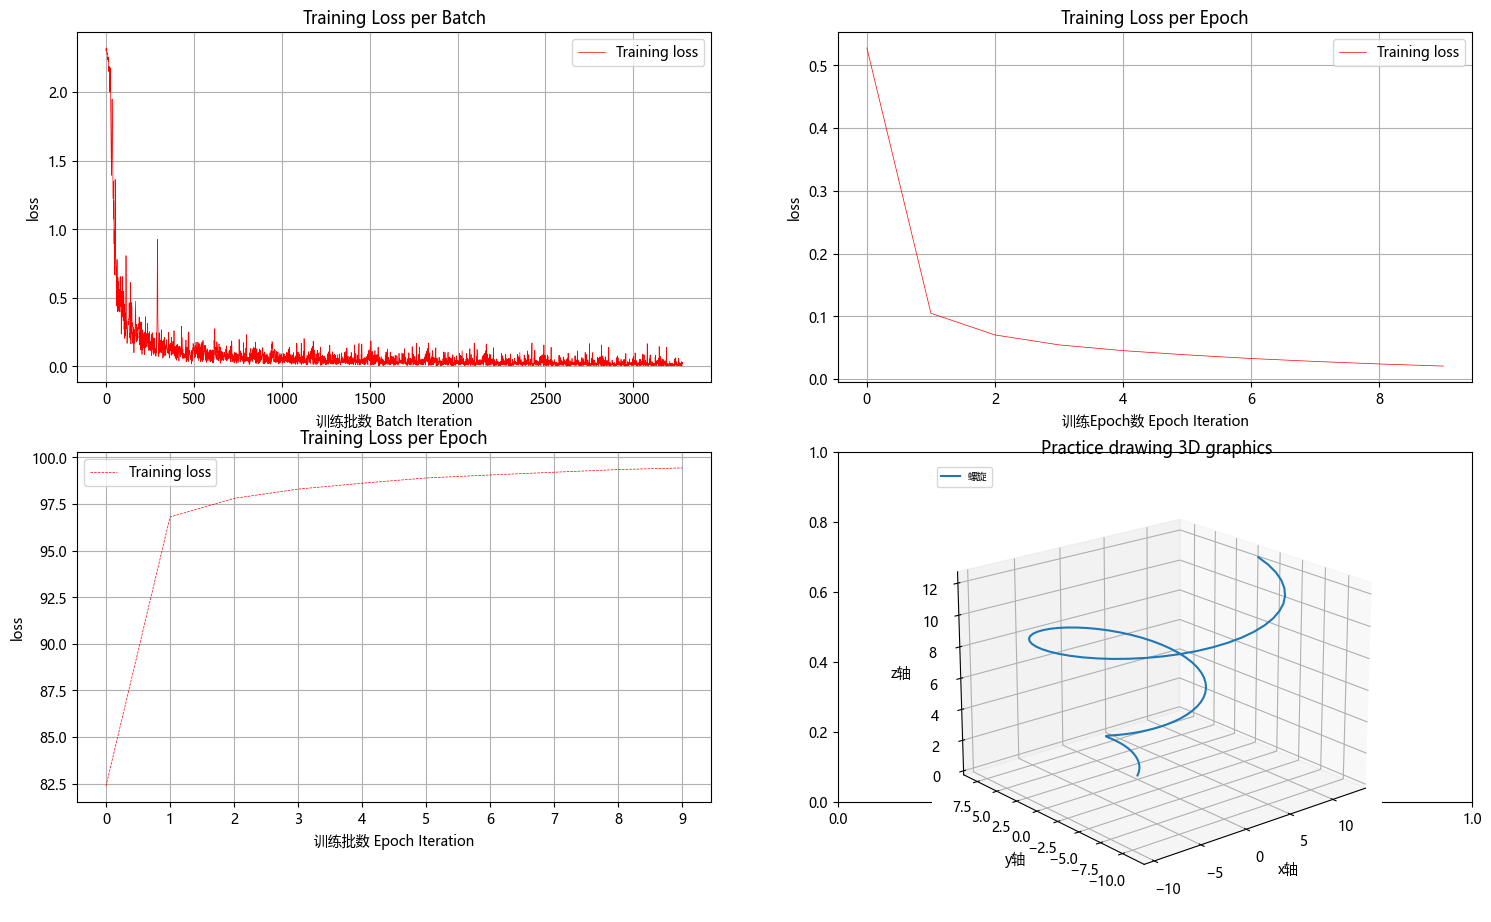

In [11]:
net, train_losses, epoch_losses, train_accuracies = trainModel() #训练，保存模型，并得到训练结果

drawTrainingResults(train_losses, epoch_losses, train_accuracies) #将结果画出来，需要训练后才能画

In [14]:
net = torch.load("digitRecognizerModel.nn") #训练并保存模型后可以直接用
ImageId = []
Label = []

for i in range(len(testX)):
    tmp = np.array(testX[i][:]) / 255
    tmp = tmp.reshape(1, 1, 28, 28)
    tmp = torch.from_numpy(tmp).float()
    b = net(tmp)

    ImageId.append(i + 1)
    Label.append(b.argmax().item())

    if i % 1000 == 0:
        print("testing", i)

myAns = pd.DataFrame({'ImageId': ImageId, 'Label': Label})
myAns.to_csv("digit-recognizer-data/myAns.csv", index=False, sep=',')

testing 0
testing 1000
testing 2000
testing 3000
testing 4000
testing 5000
testing 6000
testing 7000
testing 8000
testing 9000
testing 10000
testing 11000
testing 12000
testing 13000
testing 14000
testing 15000
testing 16000
testing 17000
testing 18000
testing 19000
testing 20000
testing 21000
testing 22000
testing 23000
testing 24000
testing 25000
testing 26000
testing 27000
